# Chapter4：ML与Ops之间的信息存储与传递机制

要想做成MLOps这样的解决方案，就必须从底层基础能力开始搭建，对于MLOps整个生命周期而言，连接各个环节的底层基础是信息的存储及传递，涉及的组件包括：**ML实验追踪、模型注册、特征存储**，这三大组件构成了MLOps的“地基”（信息存储），“Wifi”（信息传递）。所以可以说，MLOps的可重现要求（针对数据、模型及服务的版本化等），以及后续的模型管理和模型监控都是在这三大组件的基础上实现的。

* （1）介绍ML**实验跟踪**组件的基础方法和实现，该组件会存储模型离线评估的指标信息，为模板的版本化和多模型间的可视化评估提供基础信息。

* （2）介绍ML的AB在线实验组件的实现方法及其在ML生命周期起到的作用

* （3）介绍模型注册组件的实现方法，该组件会存储模型部署时设计的信息，为模型训练和推理间的元数据信息传递及模型和服务版本化管理提供基础信息。

* （4）介绍管理离线和在线特征的特征存储，该组件会储存特征的相关信息，为模型训练和推理间的特征传递及数据版本化管理提供基础信息。




# 1 ML实验跟踪

## 1.1 ML实验跟踪的定义

所谓ML实验跟踪，是MLOps的一个过程，专注于收集、组织和跟踪具有不同配置（超参数、模型大小、训练数据、参数等）的多次运行过程中产生的信息。ML实验跟踪模块会定义一个适当的实验跟踪流程，并在所有未来试验中使用该流程，能够将所有实验组织在一个空间中，在我们需要的任何时候都可以查看团队的建模成果，可以轻松跟踪进度并进行协调。

具体来说，需要具备一个集中的实验信息存储库，通过将模型实验过程的信息记录在该存储库中，可以搜索和过滤实验，快速找到需要的信息，这样无需额外的工作即可比较不同模型的指标和参数，也便于深入研究，查看你的团队都尝试了哪些内容（代码、数据版本、模型框架等）。当需要的时候，可以随时复制和重新运行实验，也可以访问实验的源数据并通过看板直接观察。其中比较常见的实验信息列举如下：
* 用于运行的脚本
* 环境配置信息（代码库或文件）
* 用于训练、评估和测试的数据版本
* 模型的超参数和参数配置信息
* 模型迭代训练后产生的权重及性能指标（如F1-score）



## 1.2 ML实验跟踪的必要性

在具体的场景下开发ML模型，数据科学家会尝试不同的算法、模型框架及数据进行大量的实验，调整参数，然后验证不同模型的性能，这个过程是繁琐复杂的。当多个数据科学家同时参与一个ML项目时，记录和比较模型就是一个具有挑战性的事。此外，ML模型实验通常需要反复进行，这就需要可重复性和版本化。

MLOps就可以解决这些问题，可以帮助数据科学家不需要花费大量的精力在设置环境和基础设施上，可以节省时间进行算法业务的研究。

## 1.3 随时随地管理实验

ML实验跟踪机制通过将实验设计的元数据进行中心化处理，可以让数据科学家和团队成员实时的看到模型实验的状态和信息。对于训练周期疆场的模型，这个举措很重要，实时查看实验运行的效果可以对效果不理想的训练做出提前终止的决策，以节省资源和时间。

团队协作时可以通过权限管理规避安全风险，即只对需要协作的模型开放权限，其他的时候团队成员各自只能看到自己的模型信息。

当采用ML实验跟踪机制，将同一个项目中正在运行的实验和以前运行的实验的元数据进行合并时，可以快速比较它们，并决定当前正在进行的实验是否有必要继续或更改算法，也可以实时看到远程训练工作是否出现问题，以随时关闭或修复错误后，重新运行。

## 1.4 ML实验跟踪和模型管理的区别

ML实验跟踪和模型管理都是MLOps的重要组成部分。
* ML实验跟踪：侧重于在**模型开发阶段**进行信息储存和可视化管理。


* 模型管理：发生在模型投产时，目标是简化从实验到生产的模型迁移，模型投产后的模型版本控制、在ML模型注册中心管理模型工件、在生产中测试各种模型版本、模型部署后的服务管理等都属于模型管理的范畴。

## 1.5 在MLOps框架增加ML实验跟踪功能

为了正确地进行ML实验跟踪，除了需要标准化跟踪模块的实验记录功能，还需要对设计的元数据进行处理，通常需要具备以下能力：

* 中央存储：是辅助ML实验跟踪的必要组件，通过提供记录功能将所有实验信息储存在同一个地方，方便随时查询。其中记录功能通常以客户端（实验跟踪API）的形式提供。


* 元数据看板（dashboard）：是实验信息的可视化界面，该组件使用保存在中央存储中的实验信息并将其展示在前端页面上，通过该组件可以直观查看并比较不同实验的各项指标和性能，为模型选择提供便利。


* 实验跟踪API：提供在中央存储中记录和查询数据的方法或API，可以对食盐产生的元数据及已经存储的元数据进行操作。


具体如下图，在部署模型之前，我们需要在实验层与部署层中间加一层实验跟踪组件，以记录不同实验的指标，并将记录的信息存储到中央存储中，同时需要在前端提供可视化能力（dashboard），将实验的元数据信息进行展示，供建模人员和管理人员决策参考。
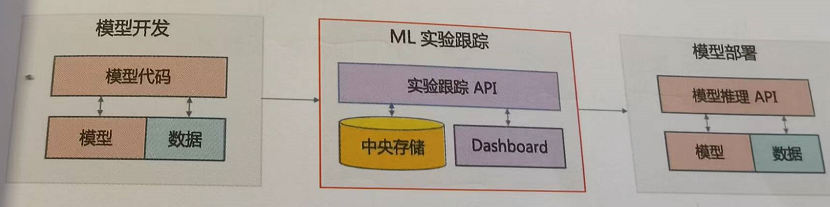

## 1.6 设计和实现ML实验跟踪API

为了便于演示，采用Python和SQLite实现ML实验跟踪的基础逻辑，对于生产级的应用，可以将代码移植到更适合生产的数据库中，比如PostgreSQL，MySQL等。

这里可以将整个训练和评估逻辑放在一个train_evaluate.py代码中。该代码将超参数集作为外部输入，而参数集作为输入并通过迭代不断输出验证分数，以完成模型的训练和评估。完整的操作流程如下图所示：

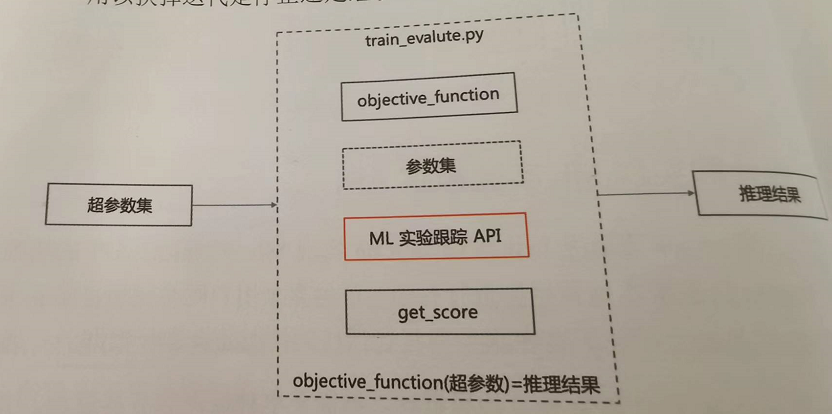

* 超参数集：通常为外部输入的数据，会影响模型的性能，但它们不属于训练数据，不能从训练数据中学习。例如，决策树的最大深度，SVM的误分类惩罚，KNN的K。这里需要注意的是，超参数是代码库的一部分，但与主函数是分开的，一般写在配置文件，比如config.py。

train_evaluate.py 代码可以被切分为4个部分：

* objective_function：定义需要优化的目标函数，该函数通常被称为优化函数。


* 参数集:参数集的类型通常会因算法的不同而有差异，可以是定义学习算法所训练的模型变量的权重。参数是由学习算法根据训练数据直接拟合的。学习的目标是找到使模型在一定意义上达到最优的参数值。


* ML实验跟踪API:负责将以上的参数集、超参数集及评估结果记录在中央存储中，这种内嵌方式可以方便记录每次迭代的信息。


* get_score:负责每次迭代时记录优化函数的分数，反映算法收敛的程度，用以抉择继续迭代还是停止。

### 1.6.1 数据库建表
接下来，就是ML实验跟踪的示例代码。首先我们可以创建一个名为model_track_center.db的库，及一个连接相应数据库的conn对象，conn对象提供了一个可以操作model_track_center.db的连接，该连接由函数get_conn定义，以便执行表的创建和查询。

In [1]:
import os
import sqlite3

# 数据库连接
def get_conn(model_track_path):
    return sqlite3.connect(os.path.join(model_track_path, 'model_track_center.db'))

接下来，为了实现跟踪数据的存储，需要创建一个model_track的跟踪主表，负责记录与模型相关的元数据信息，可以根据需要定义跟踪中的字段。同时，需要为模型迭代时产生的参数及评估日志创建表，sql代码建表如下：

In [2]:
%%file db.sql
drop table if exists model_track;
drop table if exists model_metric;
drop table if exists model_params;
drop table if exists model_task;

create table model_task
(
    task_id integer PRIMARY KEY ASC,
    task_name text not null,
    task_description text,
    tracked_time text default CURRENT_TIMESTAMP not null,
    del_flag integer default 0 not null
);
create table model_metric
(
    metric_id integer PRIMARY KEY ASC,
    model_id integer not null,
    metric_name text not null,
    metric_type text not null,
    epoch integer not null,
    metric_value float not null,
    is_best integer default 0 not null,
    tracked_time text default CURRENT_TIMESTAMP not null
);

create table model_track
(
    model_id integer PRIMARY KEY ASC,
    task_id integer not null,
    model_sequence integer not null,
    model_name text not null,
    model_description text,
    tracked_time text default CURRENT_TIMESTAMP not null,
    del_flag integer default 0 not null
);

create table model_params
(
    param_id integer PRIMARY KEY ASC,
    model_id integer not null,
    param_type text not null,
    param_name text not null,
    param_value text not null,
    tracked_time text default CURRENT_TIMESTAMP not null
);


Overwriting db.sql


我们将上面建表的sql代码保存到sql.db文件后，即可用下面代码进行标准化：

In [3]:
def create_tables(model_track_path):
    conn = get_conn(model_track_path)
    sql_script = open(os.path.join("./", 'db.sql'), 'r', encoding='utf-8').read()
    conn.executescript(sql_script)
    conn.commit()

然后我们可以把这些数据库操作的代码，保存为init_db.py文件。

In [4]:
%%file init_db.py
import os
import sqlite3

# 数据库连接
def get_conn(model_track_path):
    return sqlite3.connect(os.path.join(model_track_path, 'model_track_center.db'))

# 创建数据表
def create_tables(model_track_path):
    conn = get_conn(model_track_path)
    sql_script = open(os.path.join("./", 'db.sql'), 'r', encoding='utf-8').read()
    conn.executescript(sql_script)
    conn.commit()
    
create_tables("./")

Overwriting init_db.py


### 1.6.2 ModelTrack类实现逻辑

ML实验跟踪API定义了一个ModelTrack类，该类包含三个关键方法：

* log_param:负责记录超参数


* log_metric:负责记录每次迭代的性能指标


* log_best_param:负责记录最优参数，当然也可以在log_param里添加一个is_best字段来进行识别



In [5]:
%%file tracking_core.py
import time
import sqlite3
import os

current_path = "./"

class ModelTrack(object):
    
    def __init__(self, task_name, task_desc=''):
        self.conn = sqlite3.connect(os.path.join(current_path, 'model_track_center.db'))
        self.task_name = task_name
        self.task_desc = task_desc
        self.is_add_track = True
        self.param_dict = {}

    def _execute_sql(self,sql,values=None):
        self.conn.execute(sql, values)
        self.conn.commit()

    # 检查model_name是否重复
    def _check_model_name(self, model_name, model_count, task_id):
        if model_name == '':
            model_name = self.task_name + '_' + str(model_count + 1)

        else:
            # 判断是否有model_name
            if self._is_exist_model_name(model_name, task_id):
                model_name = model_name + '_' + str(model_count + 1)
            else:
                model_name = self.model_name

        if self._is_exist_model_name(model_name, task_id):
            return self._check_model_name(model_name, model_count, task_id)
        else:
            return model_name

    # 检查Task name 是否存在
    def _is_exist_task_name(self, task_name):

        sql = "select 1 from model_task m where m.task_name = '{}'".format(task_name)
        task_table = self.conn.execute(sql).fetchall()

        if len(task_table) != 0:
            return True
        else:
            return False

    # 检查model name 是否存在
    def _is_exist_model_name(self, model_name, task_id):

        sql = "select 1 from model_track mt where mt.task_id = {} and mt.model_name = '{}'".format(task_id, model_name)
        model_table = self.conn.execute(sql).fetchall()

        if len(model_table) != 0:
            return True
        else:
            return False

    def log_param(self, param_dict, param_type):
        self.param_dict[param_type] = param_dict

    def log_model_name(self, model_name):
        self.model_name = model_name

    def log_model_desc(self, model_desc):
        self.model_desc = model_desc

    def log_metric(self, metric_name, metric_value, epoch, is_best=0):

        if self.is_add_track:
            self._add_track_logs()
            self.is_add_track = False
        
        sql = """insert 
                 into 
                    model_metric 
                    (model_id, metric_name, metric_type, epoch, metric_value, is_best) 
                 values (?, ?, ?, ?, ?, ?)"""
        self._execute_sql(sql, (self.model_id, metric_name,"line", epoch, '%.4f'%(metric_value), is_best))
        
    def log_best_result(self, best_name, best_value, best_epoch):
        sql = "insert into best_result () values (null, ?, ?, ?, ?, ?)"
        self._execute_sql(sql, (self.sub_model_id, best_name, '%.4f' % (best_value), best_epoch, create_time))
        

    # 添加模型超参数及其他元数据
    def _add_track_logs(self):

        # 插入model
        if not self._is_exist_task_name(self.task_name):
            sql = "insert into model_task (task_name,task_description) values (?, ?)"
            self._execute_sql(sql, (self.task_name, self.task_desc))

        sql = "select task_id from model_task m where m.task_name = '{}'".format(self.task_name)
        task_id = self.conn.execute(sql).fetchall()[0][0]

        sql = "select count(1) from model_track sm where sm.task_id = {}".format(task_id)
        model_count = self.conn.execute(sql).fetchall()[0][0]

        # 插入sub model
        model_name = self._check_model_name(self.model_name, model_count, task_id)
        sql = "insert into model_track (task_id,model_sequence,model_name,model_description) values (?, ?, ?, ?)"
        self._execute_sql(sql, (task_id, model_count + 1, model_name, self.model_desc))

        sql = "select model_id from model_track sm where sm.task_id = ? and sm.model_name = ?"
        self.model_id = self.conn.execute(sql, (task_id, model_name)).fetchall()[0][0]
        print(self.model_id,model_name,"self.model_id")
        
        # 插入model params
        for param_type, value in self.param_dict.items():

            for param_name, param_value in value.items():
                sql = "insert into model_params (model_id, param_type, param_name, param_value) values (?, ?, ?, ?)"
                self._execute_sql(sql, (self.model_id, param_type, param_name, str(param_value)))
                
    def close(self):
        self.conn.close()

Writing tracking_core.py


通过前面实现的ML实验跟踪API可以使用简单的几步来实现记录模型训练性能日志。首先初始化 ModelTrack类，初始化的时候需要指定模型任务的名称（task_name）和任务备注（task_desc）,同一个模型任务可以包含多个子模型。下面使用MLflow的示例，使用前面封装的API进行实验跟踪：

In [6]:
%%file test_tracking.py
import os
from random import random, randint
from tracking_core import  ModelTrack

model_track = ModelTrack(task_name="churn_model_mlops",task_desc = "流失模型研究")


if __name__ == "__main__":

    model_track.log_model_name("model-A")
    model_track.log_model_desc("模型-A")
    # Log a parameter (key-value pair)
    model_track.log_param({"param1" : randint(0, 100)},param_type = "logistic_param")

    # Log a metric; metrics can be updated throughout the run
    model_track.log_metric("foo", random(), epoch=1,is_best=0)
    model_track.log_metric("foo", random() + 1, epoch=1,is_best=0)
    model_track.log_metric("foo", random() + 2, epoch=1,is_best=0)

Writing test_tracking.py


首先初始化ModelTrack类，填入与任务相关的信息，在迭代前将于模型相关的属性及超参数信息存入中央存储，其中超参数以字典的格式存入。接下来，在模型进入训练环节时，在每次迭代周期内都可以添加评估指标数据，评估指标可以为F1-score，loss，recall等，每次迭代都会调用该api，都会把记录的数据持久化存入中央存储，前端人员就可以根据数据的内容设计看板。

# 2 A/B在线实验

ML实验跟踪侧重于模型的开发阶段，用于评估和记录将模型部署到生产环境之前的模型性能指标和相关信息。虽然礼县实验可用于证明模型在历史数据上表现出了足够好的性能，但这些实验不能简历模型和用户交互之间的因果关系。当ML被引入实时的生产系统以驱动特定的用户行为时，如提高点击率或参与度，我们需要通过实时跟踪具体的业务指标来衡量这些指标的进展，这些指标被称为关键绩效指标（KPI），执行这种在线跟踪和验证的方式被称为在线实验。

AB在线实验是实际应用场景中最经常使用的统计技术。当将其应用于在线模型评估时，它允许我们回答这样的问题，新模型B在生产中是否比现有模型A的效果更好？

## 2.1 确定实验的范围与目标

一旦我们对数据中的关系有了更深入的理解，并确定了相关的KPI指标，就可以开始定义实验的范围，在设计实验之前，通常需要考虑以下四个问题。

* 要创建的实验是否重要。因为一旦创建实验就意味着相应的会见、金钱和资源的投入，应确保实验的结果能正向影响业务、产品和营销决策。


* 能否在这个实验中测量相关的KPI指标。从业务角度出发，最不希望看到的就是无法量化这些KPI指标。一定要确保这些指标是可以量化的。


* 能否检测到影响。要评估在线实验跟踪的指标变化是否有意义，是否需要足够大的样本量才能检测出来。


* 是否满足商业目标，从商业角度来看，需要提前考虑如果实验指标较好，其影响是否有意义。换句话说，即是你的实验所测试的模型带来了统计上的显著提升，如果它只影响少数的几个用户，可能就不值得大规模投入了。

如果上述任何一个问题答案为否，就需要在调整实验目标或KPI的设定。

## 2.2 最小样本量的确定方法

在线实验的理论核心就是最小样本量的确定，其中涉及了：
* 抽样（分流）方案的选择
* 统计假设的定义
* 所需最小样本量的确定

### 2.2.1 抽样方案的选择

抽样方案是对感兴趣的人群进行抽样的方法，需要考虑包含任何潜在的抽样偏差，以确保利益相关者了解不同的抽样方法及这些方法对实验结果的潜在影响。

### 2.2.2 统计假设的定义

零假设（T0）和备择假设（T1）的设计涉及试验定义的核心。需要清楚的描述T0和T1是什么。通常情况下，T0就是控制组（旧版本或现版本），T1就是新版本。实验的目标是检验是否有足够多的证据来拒绝T0，来接受T1。

统计误差是假设的关键部分，具体来说就是要计算两种错误类型：
* 第一类错误（假阳性）：无辜者定罪
* 第二类错误（假阴性）：有罪者无罪释放

计算这两类错误的方法是：
* 第一类错误：显著性水平检验。将显著性水平设为5%，也就是95%置信水平（confidence level）
* 第二类错误：功效统计量，就是检测实验组和对照组之间差异（如果真的存在差异）的能力

下图展示了变量的变化（效应量的大小和样本量大小）是如何影响统计检验的功效的,图中显示了随着观测者数量（x轴）的增加，三种不同效应量（es）的统计功效（y轴）的影响。，这里假设最小统计功效为80%。
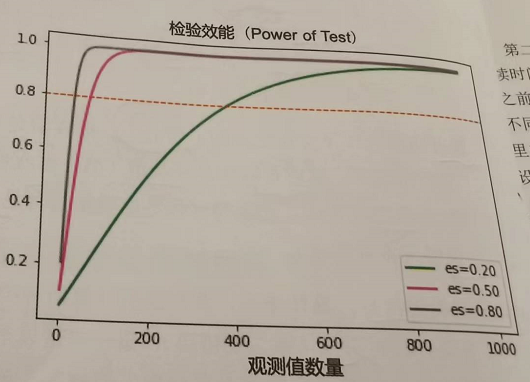

了解影响的大小或针对给定人群可以预期的结果非常重要。如果我们希望在测试中看到的变化越大，效应量越大（es越小），那么所需的最小样本量就越小。反之亦然。换句话说，如果你想检测较大的差异，你将在测试中使用较少的用户进行检测，但如果你想找到更精细的细小差异，那么在测试就要包含更多的用户。

### 2.2.3 所需最小样本量的确定

一旦定义了显著性水平，功效和效应量，就可以运行功效分析来确定最小样本量，以便检测正在测试的实验是否有意义。该检验通常使用p值进行解释，p值是在T0假设为真的情况下，观察结果的概率。

在解释显著性检验的p值（必须指定显著性水平）时，如果p值小于显著性水平，则显著性检验的结果被称为“统计学上有意义”，这意味着T0（没有显著差异）被拒绝。

最小样本量的计算示例入选所示，用python的statsmodels库即可实现，需要指定显著性水平(alpha)、效应量(effect)、最小统计功效(power)等：


In [7]:
from statsmodels.stats.power import TTestIndPower

# 功效分析参数
alpha = 0.05
effect = 0.05
power = 0.8

# 功效分析表现
analysis = TTestIndPower()
result = analysis.solve_power(effect_size=effect,power=power,alpha=alpha)
print('最小样本量：{}'.format(result))

最小样本量：6280.049008707864


## 2.3 对ML模型进行A/B测试

运行AB测试的第一步就是确定实现商业目标的衡量指标。在实验中，这个指标通常使用商业结果的代理指标，而不是商业结果的直接度量。首选代理指标的原因是速度快且可量化，一个可以在数小时或数天内测量的指标可以使我们快速整合实验反馈。

第二步是确定实验本身的参数，需要确定的两个参数分别是样本量和实验的持续时间，同时需要提前设定对照组和控制组。在实验上线后且预设的样本量达到之前，用户会按照预设的流量比例被随机分流到对照组合控制组，用户丠分裂带不同组决定了他们会看到不同的ML模型。实验的持续时间取决于功效分析，这里的功效分析指的是对假阴性概率及显著性水平的计算。

## 2.4 在MLOps框架增加AB在线实验

接下来，就需要在MLOps流程中嵌入AB在线实验功能。这在实际运行时，意味着要同时操作多个模型，并确保被分配到控制组和对照组的用户能够看到正确的模型产生的结果。顺利做到这点取决于公司的数据基础设施和数据模型，具体的设计模型主要有两种：

### 2.4.1 内嵌模式

这种模式是将不同的模型封装在AB实验API的后端，如下图所示。我们需要在模型部署阶段新增一层AB实验的API，将多个模型封装在API的后端，同时需要在模型发布后对反馈日志和AB实验参数进行保存，所以这里需要将反馈日志和参数信息记录到中央存储中。

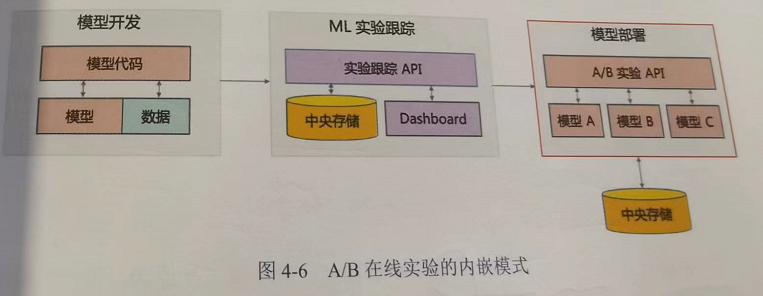

我们通过简单的flask来实现它的基本逻辑。

假设 model_A是当前部署的模型，可以通过向 /predict 端点发出HTTP请求来获取 model_A的预测结果：

In [15]:
from flask import Flask

app = Flask(__name__)

@app.route("/predict")
def predict():
    features = request.get_json['features']
    return model_A.predict(features)

现在我们根据用户ID将用户分配到控制组和对照组，假设模型A为控制组，在代码中定义为model_A,模型B（model_B）和模型C(model_C)为对照组。内嵌的路由逻辑是将用户与模型服务应用程序中的模型相匹配，也就是在单个应用程序中提供多个模型：

In [16]:
from hashlib import sha1
import random

alternatives = ['model_A','model_B','model_C']

model_A = 'RF'
model_B = 'LR'
model_C = 'lightgbm'


# 将模型名称映射到模型对象
models = {
    'model_A':model_A,
    'model_B':model_B,
    'model_C':model_C
}

def get_hash(user_id):
    hashed = sha1(user_id).hexdigest()[:7]
    return int(hashed,16)

def choose_alternative(user_id):
    rnd = random.random()
    idx = get_hash(user_id) % len(alternatives)
    return alternatives[idx]

@app.route("/predict_models")
def predict_models():
    features = request.get_json['features']
    user_id = request.get_json['user_id']
    model_selected = choose_alternative(str(user_id))
    model = models[model_selected]
    return model.predict(featuresures)


这种模式比较容易理解，但不是一个好模式，其中有三个原因：

* 任务分工难度和测试复杂度高：在引入在线实验之前，我们部署的模型只负责处理对模型的请求，这个任务可以用几行代码封装完成。但是如果将实验逻辑加入到API中，就会增加应用程序的任务、代码库、依赖以及编写更多测试内容。


* 增加代码及模型会增加应用程序失败的风险：在淡漠型的情况下，如果有模型失败的情况，只需独立修复该模型服务即可，更新模型也只需要独立更新，不对对其他模型产生影响。而在内嵌模式下，如果模型调用失败，在修复的时候需要对整个服务进行调整，势必会影响到其他模型的调用。


* 强依赖于开发人员来完成：每次创建实验都需要开发人员配合，而实际应用可能需要很多实验，这种模型会降低实验验证的效率。

### 2.4.2 分离模式

更好的方法是在模型推理服务的客户端和业务系统之间添加一层额外的抽象层，该抽象层负责根据实验的设置路由传入的请求。对于这种模式，每个训练好的模型都托管在独立的环境中，并且各自对应一个模型推理服务，流量先通过AB实验API进行分流，将指令路由到模型推理服务的客户端，也就是模型推理服务和AB在线服务测试是分离的，这样如果模型推理服务出现问题，也不会影响到AB在线服务和其他模型服务的正常运行。

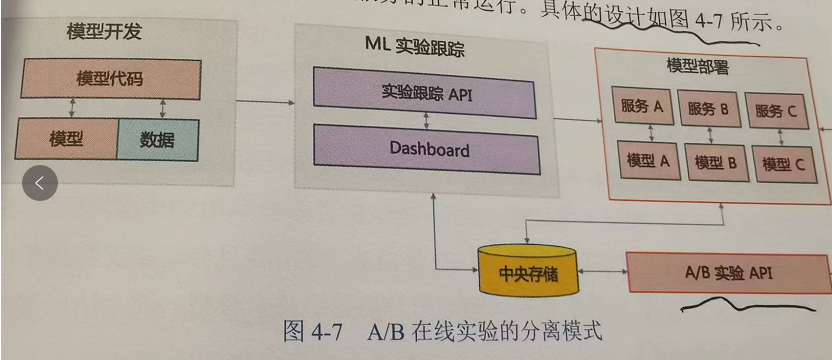

该模式首先解决了责任下放的问题，整个应用由两层服务组成。模型推理服务负责执行预测，AB在线实验的服务负责分流和反馈日志的收集，将传入的推理请求路由到适当的模型推理服务上，同时也会接受来自客户端的反馈信息，以便实时展示实验的效果。运行实验时，数据科学家可以根据实验进展打开、关闭操作，不需要开发人员参与，这样极大的提高了实验的灵活性。

## 2.5 MLOps中的A/B实验管理

我们就可以设计一个简单的AB实验管理界面，如下图所示：
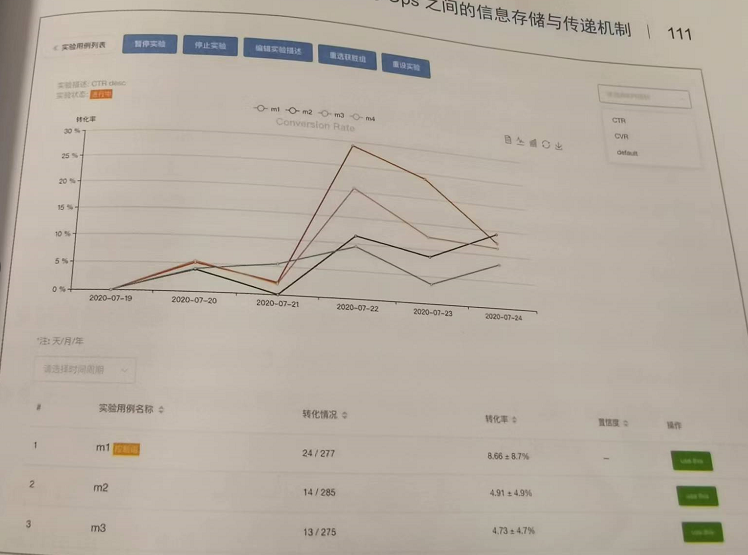


然后实验的元数据信息会保存到中央存储，就可以查看不同的KPI指标，也可以进行停止实验等操作。
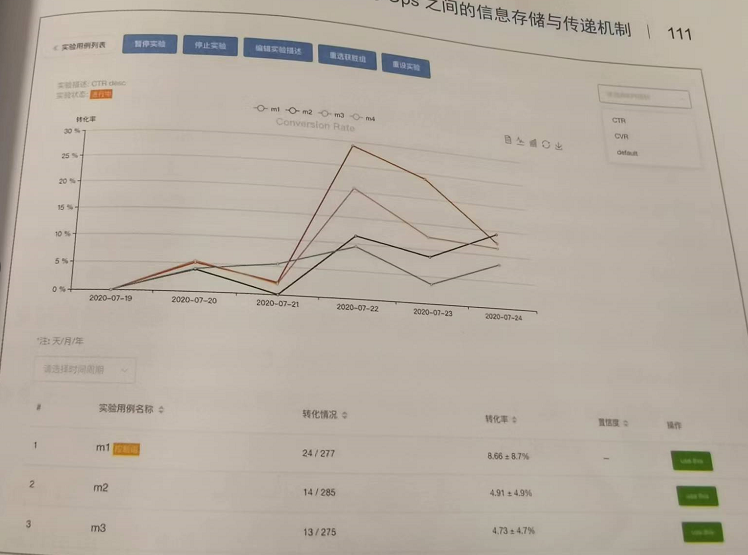

# 3 模型注册

## 3.1 模型注册的定义

假设数据团队


# 4 特征存储